In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# import emukit
import GPy
# from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
# from emukit.core.initial_designs.random_design import RandomDesign
# from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

# from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
# from emukit.core.acquisition import IntegratedHyperParameterAcquisition

from rgpe import compute_rank_weights

In [23]:

import numpy as np
from scipy.spatial.distance import cdist
from emukit.core.initial_designs.latin_design import LatinDesign

def find_y_by_x(x_input, X_all, Y_all):  #一通过x找到对应的y的函数
    # 确保 x_input 是一个二维数组
    if len(x_input.shape) == 1:
        x_input = x_input.reshape(1, -1)

    # 初始化一个列表来存储所有结果
    all_results = []

    # 遍历 x_input 中的每个特征向量
    for x in x_input:
        # 使用 NumPy 的函数 argwhere 来查找 x 在 X 中的位置
        indices = np.argwhere(np.all(X_all == x, axis=1))

        # 初始化一个列表来存储匹配的 Y 值
        matching_y_values = []

        # 遍历匹配的位置
        for index in indices:
            match_index = index[0]
            matching_y_values.append(Y_all[match_index])

        all_results.append(matching_y_values)
    
    all_results = np.array(all_results)
    return all_results

def x_normalizer(X, var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_norm

def x_denormalizer(x_norm, var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_original




# def get_closest_array(x_init, X_all):
#     # 计算 x_init 中每个点与 X_all 中所有点之间的距离
#     distances = cdist(x_init, X_all)   
#     # 找到每个点最近的索引
#     closest_indices = np.argmin(distances, axis=1)    
#     # 根据索引获取最近的点
#     closest_array = X_all[closest_indices]  
#     return closest_array

def get_closest_array(x_init, X_all):
    X_all_copy = X_all.copy()
    closest_array = []
    
    for x in x_init:
        # 计算 x 与 X_all_copy 中所有点之间的距离
        distances = cdist([x], X_all_copy)[0]
        # 找到最近的索引
        closest_index = np.argmin(distances)
        # 根据索引获取最近的点
        closest_point = X_all_copy[closest_index]
        # 将最近的点添加到结果数组中
        closest_array.append(closest_point)
        # 从 X_all_copy 中移除这个点
        X_all_copy = np.delete(X_all_copy, closest_index, axis=0)
        
    return np.array(closest_array)


# # 计算两个点之间的欧几里得距离
# def euclidean_distance(point1, point2):
#     return np.sqrt(np.sum((point1 - point2) ** 2))

# # 找到X_all中与x_init每个元素最近的点
# def get_closest_array(x_init, X_all):
#     closest_array = []
#     for point in x_init:
#         distances = np.array([euclidean_distance(point, x) for x in X_all])
#         closest_idx = distances.argmin()
#         closest_array.append(X_all[closest_idx])
#     return np.array(closest_array)

def create_latin_design(X_all):
 
    x_array = [X_all[:, i] for i in range(X_all.shape[1])]
    
    num_columns = X_all.shape[1]
    parameter_space = ParameterSpace([ContinuousParameter(f'x{i+1}', 0, 1) for i in range(num_columns)])
    design = LatinDesign(parameter_space)
    
    return x_array , design



# 导入目标任务

In [24]:
import pandas as pd
import numpy as np
import os

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Goldstein' 
# file_path = os.path.join(folder_path, 'goldstein_data.xlsx')

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\matminner_processed' 
# file_path = os.path.join(folder_path, 'Ti.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去

folder_path = r'C:\Users\13282\Desktop\papercode\data\Aryl\original_processed' 
file_path = os.path.join(folder_path, 'aryl-15.xlsx')  # y 记得加负号 


df = pd.read_excel(file_path)

#去除存在nan的点
# nan_indices = np.isnan(Y)
# X = X[~nan_indices.flatten()]
# Y = Y[~nan_indices.flatten()]
print(df.shape)

X_all = df.iloc[:, :-1].values  
Y_all = - df.iloc[:, -1].values   

print(X_all.shape,Y_all.shape)

(264, 9)
(264, 8) (264,)


# x和y预处理

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler()
X_all = min_max_scaler.fit_transform(X_all)

#去除存在nan的点
nan_indices = np.isnan(Y_all)
true_indices = np.where(nan_indices)[0]
print("nan 的索引:", true_indices)

X_all = X_all[~nan_indices.flatten()]
Y_all = Y_all[~nan_indices.flatten()]

print(X_all.shape,Y_all.shape)

nan 的索引: [58]
(263, 8) (263,)


In [26]:
y_min = np.nanmin(Y_all)
y_min

-98.29

# 设置参数

In [27]:
from emukit.bayesian_optimization.acquisitions import EI_transfer

from emukit.bayesian_optimization.acquisitions import SampleMaxVariance, SampleMinEuclideanDistance, \
                                                SampleVarianceEuclideanDistance,  SampleYDistance

file_name = "standard_bo" 

n_loop = 40        #循环求均值次数，也即整个流程重复次数
maxiter = 50       #模型迭代次数

rdm_sample = 3

# num_x_init = 20

model_var = 0.1
num_restarts = 5
bs = 1
top = 1 


# 开始优化

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
import tqdm

import logging
logging.getLogger('variance').setLevel(logging.ERROR)
logging.getLogger('lengthscale').setLevel(logging.ERROR)

var_array , design = create_latin_design(X_all)


df_min_y= pd.DataFrame()


first_iteration = True  # 初始化布尔变量，表示是否是第一次迭代

for tri in tqdm.tqdm(range(n_loop), desc="Loop Progress"): 
    
    # 进行初始选点
#     np.random.seed(42)  # 设置随机种子以确保结果可重现
#     x_init = design.get_samples(lhs_sample)                        
#     x_init_original = get_closest_array(x_denormalizer(x_init, var_array),X_all)
#     X = x_init_original
        
    random_indices = np.random.choice(X_all.shape[0], rdm_sample , replace=False)  
    X = X_all[random_indices] 
    
    
#     Y = find_y_by_x(X, X_all, Y_all)
#     # 初始化模型
#     input_dim = len(X[0])
#     ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#
#     model_gpy = GPRegression(X,Y, ker)
#     emukit_model = GPyModelWrapper(model_gpy)  
    
#     for i in range( num_x_init - lhs_sample):
        
#         select_acquisition = SampleMinEuclideanDistance(emukit_model)   
#         acq_plot = select_acquisition.evaluate(X_all)
#         select_acquisition_nom = (acq_plot - np.min(acq_plot)) / (np.max(acq_plot) - np.min(acq_plot))
#         #将已经采样点的获取函数值设为0
#         for x_row in X:
#             indices = np.where(np.all(X_all == x_row, axis=1))[0]
#             select_acquisition_nom[indices] = 0
            
#         sort_index = np.argsort(select_acquisition_nom, axis =0)
#         x_new = []
#         for i in sort_index[-top:]:
#                 x_new.append(X_all[i][0])
#         x_new=np.array(x_new)
#         y_new = find_y_by_x(x_new, X_all, Y_all)
        
#         X = np.append(X, x_new, axis=0)
#         Y = np.append(Y, y_new, axis=0)
        
#         model_gpy = GPRegression(X, Y, ker)
#         emukit_model = GPyModelWrapper(model_gpy)   

# 初始化模型
    Y = find_y_by_x(X, X_all, Y_all)
    input_dim = len(X[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)# 
    ker.randomize()
    ker.lengthscale.constrain_bounded(0.01, 10)
    ker.variance.constrain_bounded(1e-2, 1e4) 
    model_gpy = GPRegression(X,Y, ker)
    model_gpy.Gaussian_noise.variance = model_var**2
    model_gpy.Gaussian_noise.variance.fix()
    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
    emukit_model = GPyModelWrapper(model_gpy)   
    
    
#进行优化迭代
   
    min_y = []
    
    for i in range(maxiter):


        ei_acquisition = ExpectedImprovement(emukit_model)
        ei_plot = ei_acquisition.evaluate(X_all)
        ei_acquisition_nom = (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot))
        
        new_acquisition = ei_acquisition_nom 
        
#将已经采样点，对应y为nan 的点的 获取函数值设为0
        for x_row in X:
            indices = np.where(np.all(X_all == x_row, axis=1))[0]
            new_acquisition[indices] = 0
            
        sort_index = np.argsort(new_acquisition, axis =0)
        x_new = []
        for i in sort_index[-top:]:
                x_new.append(X_all[i][0])

        x_new=np.array(x_new)
        y_new = find_y_by_x(x_new, X_all, Y_all)

        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        
        model_gpy = GPRegression(X, Y, ker)
        model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
        emukit_model = GPyModelWrapper(model_gpy)
        
        min_y.append(min(Y).item())
        
        
             
    # 将 DataFrame 追加到主 DataFrame 中
    df_min_y = pd.concat([df_min_y, pd.DataFrame([min_y])], ignore_index=True)





Loop Progress: 100%|██████████| 40/40 [26:18<00:00, 39.46s/it]


In [29]:
print(X.shape,df_min_y.shape)

(53, 8) (40, 50)


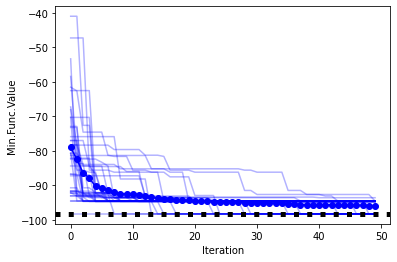

In [30]:
mean_data = df_min_y.mean()


# 定义透明度参数
alpha_increment = 0.3 / len(df_min_y)

for i, (index, row) in enumerate(df_min_y.iterrows()):

    # 计算当前透明度
#     alpha = 0.1 + alpha_increment * (i + 1)
    alpha = 0.3
    # 绘制折线图，并设置颜色和透明度
    plt.plot(row.index, row.values, color='blue', alpha=alpha)
    
    
plt.plot(mean_data.index, mean_data.values,  marker='o', linestyle='-', color='blue')

y_min = np.nanmin(Y_all)
plt.axhline(y_min, color='black', linestyle=':', linewidth=5,)
# 添加图例
# plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Min.Func.Value')

# 显示图形
plt.show()

In [31]:
import os

folder_name = r'C:\Users\13282\Desktop\papercode\trasfer\result\Aryl\aryl15'

# 确保文件夹存在，如果不存在则创建
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 构建完整的文件路径，包括文件夹名称和文件名
miny_name = os.path.join(folder_name, f'{file_name}_miny.xlsx')
df_min_y.to_excel(miny_name, index=False, engine='openpyxl')




# 检测采样

In [32]:
import numpy as np
from collections import Counter

def find_duplicate_rows(X):
    Z = X
    # 将数组中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in Z]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 初始化总的重复次数
    total_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 打印重复行的行号（索引）和它们的重复次数，并计算总的重复次数
    for index, row in enumerate(Z):
        row_tuple = tuple(row)
        if row_tuple not in counted_rows:
            count = row_counts[row_tuple]
            if count > 1:
                print(f"行 {index + 1} 重复了 {count} 次")
                total_duplicate_count += count
            counted_rows.add(row_tuple)  # 将该行添加到已计数的行集合中

    # 打印总的重复次数
    print(f"总的重复次数为: {total_duplicate_count}")

    # 初始化总的不同重复行数
    total_unique_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 计算不同的重复行数
    for row_tuple, count in row_counts.items():
        if count > 1:
            total_unique_duplicate_count += 1
            counted_rows.add(row_tuple)

    # 打印总的不同重复行数
    print(f"总的不同重复行数为: {total_unique_duplicate_count}")
    
    
find_duplicate_rows(X)


总的重复次数为: 0
总的不同重复行数为: 0


In [33]:
Y_all_reshaped = Y_all.reshape(-1, 1)
find_duplicate_rows(Y_all_reshaped)

行 1 重复了 2 次
行 28 重复了 2 次
行 30 重复了 2 次
行 52 重复了 5 次
行 65 重复了 2 次
总的重复次数为: 13
总的不同重复行数为: 5
